<a href="https://colab.research.google.com/github/Abhi-1114/Music-streamingg-website-/blob/main/CompVProj2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 📌 Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
# 📌 Step 2: Unzip your dataset (Update your file path accordingly)
import zipfile
import os

zip_path = '/content/drive/MyDrive/processed_data.zip'  # <-- Update this path if needed
extract_dir = '/content/data'

os.makedirs(extract_dir, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("✅ Zip file extracted to:", extract_dir)


✅ Zip file extracted to: /content/data


In [3]:
# Check the contents of the extracted directory
import os
print(os.listdir('/content/data'))


['processed_data']


In [11]:
# 📌 Step 3: Dataset & DataLoader Setup
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
from torchvision import transforms

# ✅ Updated Dataset Class (separate transform for image and mask)
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_files = sorted([
            file for file in os.listdir(image_dir)
            if file.endswith(('.jpg', '.png', '.jpeg'))
        ])
        self.mask_files = {f for f in os.listdir(mask_dir) if f.endswith('.png')}

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name.replace('.jpg', '.png'))

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        # Apply same resizing, but treat mask differently
        image = transforms.Resize((256, 256))(image)
        image = transforms.ToTensor()(image)

        mask = transforms.Resize((256, 256))(mask)
        mask = transforms.ToTensor()(mask)
        mask = (mask > 0.5).float()  # force binary mask

        return image, mask


# 📁 Set paths
image_dir = '/content/data/processed_data/train'
mask_dir = '/content/data/processed_data/masks'

# 📐 Transformations
transform = transforms.Compose([
         transforms.Resize((256, 256)),
         transforms.RandomHorizontalFlip(),  # Add horizontal flipping
         transforms.RandomRotation(10),    # Add random rotation
         # ... other augmentations like random cropping, color jitter, etc.
         transforms.ToTensor()
     ])

dataset = SegmentationDataset(image_dir, mask_dir, transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)


In [12]:
# 📌 Step 4: UNet-like model
import torch.nn as nn
import torch.nn.functional as F

class SimpleUNet(nn.Module):
    def __init__(self):
        super(SimpleUNet, self).__init__()
        self.enc1 = nn.Sequential(nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(), nn.Conv2d(16, 16, 3, padding=1), nn.ReLU())
        self.pool = nn.MaxPool2d(2, 2)
        self.enc2 = nn.Sequential(nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.Conv2d(32, 32, 3, padding=1), nn.ReLU())

        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec1 = nn.Sequential(nn.Conv2d(48, 16, 3, padding=1), nn.ReLU(), nn.Conv2d(16, 16, 3, padding=1), nn.ReLU())
        self.final = nn.Conv2d(16, 1, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        d = self.up(e2)
        d = torch.cat([d, e1], dim=1)
        d = self.dec1(d)
        return self.final(d)

model = SimpleUNet().to('cuda' if torch.cuda.is_available() else 'cpu')
# 📌 Dice Loss Function
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = torch.sigmoid(inputs)  # convert logits to probabilities
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
        return 1 - dice
# 📌 Combined Loss: BCE + Dice
bce = nn.BCEWithLogitsLoss()
dice = DiceLoss()

def criterion(outputs, masks):
    return bce(outputs, masks) + dice(outputs, masks)



In [15]:
num_epochs=10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    total_pixels = 0
    correct_pixels = 0

    for images, masks in dataloader:
        images, masks = images.to(device), masks.to(device)
        masks = masks.float()

        outputs = model(images)
        loss = criterion(outputs, masks)


        optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # ✅ Threshold for predictions
        preds = torch.sigmoid(outputs)
        preds = (preds > 0.5).float()

        # ✅ Accuracy calculation
        correct_pixels += (preds == masks).float().sum()
        total_pixels += torch.numel(masks)

    avg_loss = running_loss / len(dataloader)
    pixel_accuracy = correct_pixels / total_pixels

    loss_history.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {pixel_accuracy:.4f}")


Epoch [1/10], Loss: 0.0208, Accuracy: 0.9976
Epoch [2/10], Loss: 0.0205, Accuracy: 0.9976
Epoch [3/10], Loss: 0.0208, Accuracy: 0.9976
Epoch [4/10], Loss: 0.0206, Accuracy: 0.9976
Epoch [5/10], Loss: 0.0209, Accuracy: 0.9976
Epoch [6/10], Loss: 0.0208, Accuracy: 0.9976
Epoch [7/10], Loss: 0.0210, Accuracy: 0.9976
Epoch [8/10], Loss: 0.0216, Accuracy: 0.9976
Epoch [9/10], Loss: 0.0212, Accuracy: 0.9976
Epoch [10/10], Loss: 0.0213, Accuracy: 0.9976


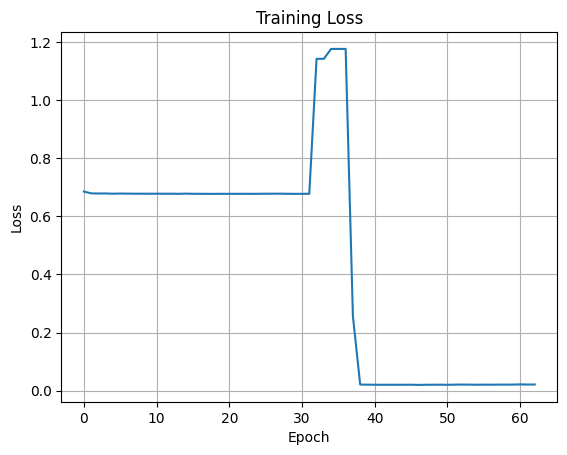

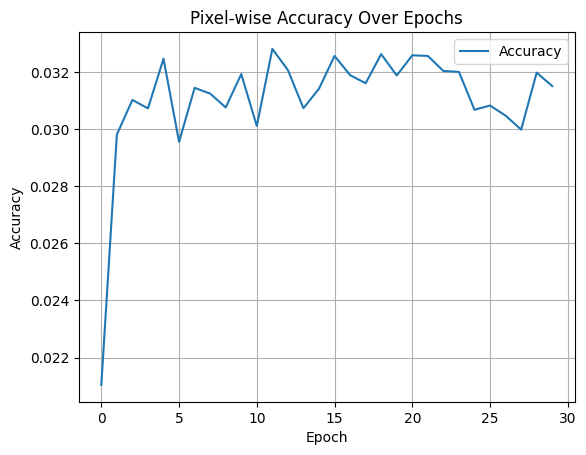

In [16]:
# 📌 Step 6: Plotting Loss
import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()
plt.plot(accuracy_history, label="Accuracy")
plt.title("Pixel-wise Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.show()


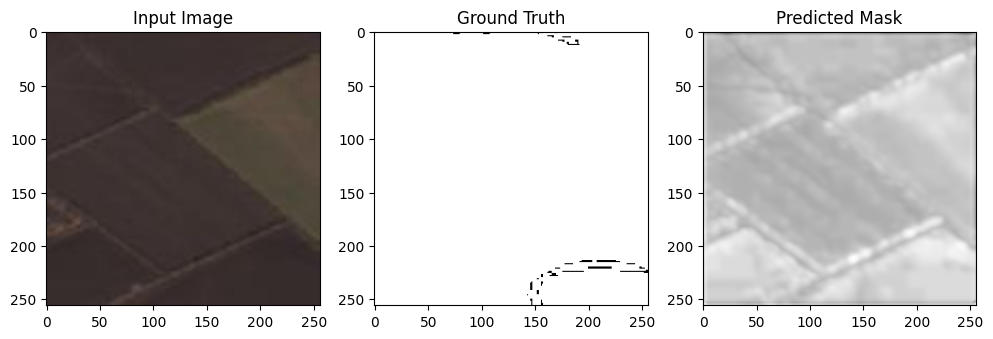

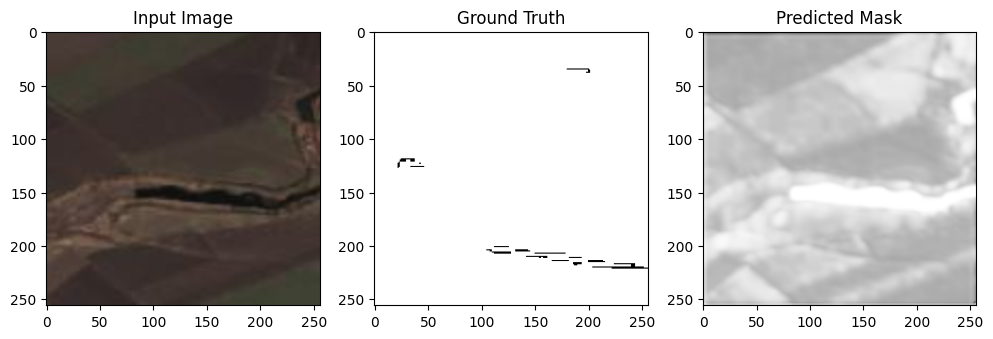

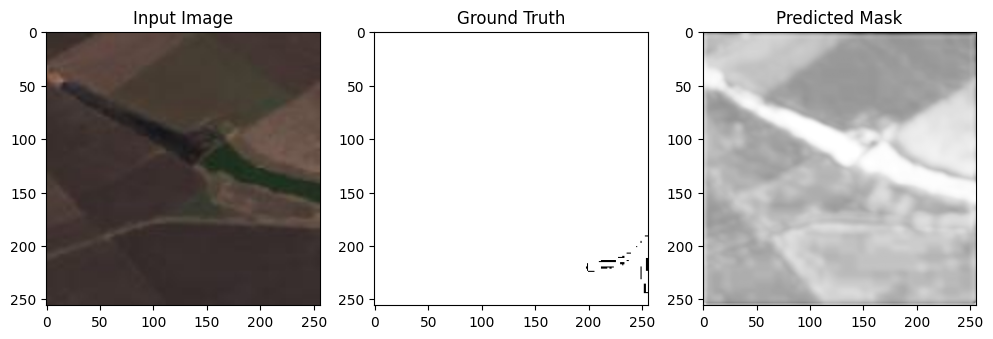

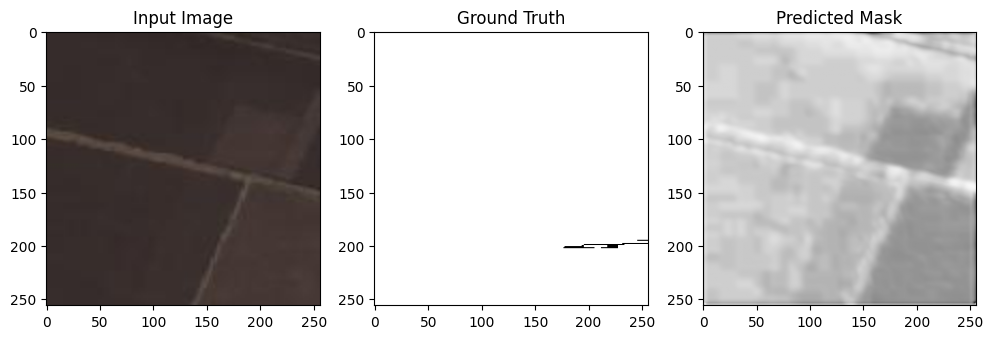

In [17]:
# 📌 Step 7: Visualizing Predictions
import torchvision.transforms.functional as TF

model.eval()
with torch.no_grad():
    images, masks = next(iter(dataloader))
    images = images.to(device)
    outputs = torch.sigmoid(model(images)).cpu()

    for i in range(min(4, len(images))):
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.imshow(TF.to_pil_image(images[i].cpu()))
        plt.title("Input Image")

        plt.subplot(1, 3, 2)
        plt.imshow(TF.to_pil_image(masks[i].cpu()), cmap="gray")
        plt.title("Ground Truth")

        plt.subplot(1, 3, 3)
        plt.imshow(outputs[i][0], cmap="gray")
        plt.title("Predicted Mask")

        plt.show()
